In [1]:
import os
import torch

save_dir = os.path.expanduser(os.environ["YOLO_MODELS"])
checkpoint_pth = max([f for f in os.listdir(save_dir) if f.endswith(".pth")])

In [2]:
from models import YOLOv1
from data.VOC_Dataset import VOC_Dataset
from data import DATA_HOME

from ipdb import set_trace
from torch.utils.data import DataLoader
from numpy import array
from multiprocessing import cpu_count
import random 
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

random.seed(1)
torch.manual_seed(1)

In [3]:
import platform

_voc_root = f"{DATA_HOME}/VOCdevkit/VOC2007"
voc_ds = VOC_Dataset(_voc_root)
BS = 1

def collate_fn(data):
    # output: 7 * 7 * 30
    # S * S * ((x, y, w, h, confidence) * B=2 + C=20)
    # make img batch and label batch
    imgs, labels, classes = zip(*data)
    # inhomegenous shape label, since each image has different number of objects
    # label's dimension: (Batch size, # of objects in each image, 4 coords)
    return torch.tensor(array(imgs), dtype=torch.float), labels, classes
    
if platform.system() == "Windows":
    loader = DataLoader(voc_ds, batch_size=BS, pin_memory=True, shuffle=True, collate_fn=collate_fn)
else:
    loader = DataLoader(voc_ds, batch_size=BS, pin_memory=True, shuffle=True, num_workers=4, collate_fn=collate_fn)

class dict:  {'pottedplant': 0, 'chair': 1, 'train': 2, 'bird': 3, 'car': 4, 'aeroplane': 5, 'boat': 6, 'horse': 7, 'bicycle': 8, 'diningtable': 9, 'motorbike': 10, 'dog': 11, 'sofa': 12, 'tvmonitor': 13, 'bus': 14, 'bottle': 15, 'cow': 16, 'cat': 17, 'sheep': 18, 'person': 19}


In [4]:
yolo = YOLOv1().to(device=device)

S = 7 # num of rows/cols
C = 20 # num of classes
B = 2 # num of bounding boxes

lamba_coord = 5
lamba_noobj = 0.5

In [5]:
from utils.display import display_image_bbox
from utils.metrics import xywh_2_xxyy
import numpy as np

with torch.no_grad():
    for _, (batch, labels, classes) in enumerate(loader):
        res = yolo(batch.to(device=device)).squeeze(0)

        boxes = []
        for i in range(res.shape[1]):
            for j in range(res.shape[2]):
                cell1 = res[:, i, j][:5]
                cell2 = res[:, i, j][5:10]
                boxes.append(cell1.detach().cpu().numpy())
                boxes.append(cell2.detach().cpu().numpy())
                

        boxes = list(map(xywh_2_xxyy, boxes))

        boxes = [np.maximum(.0, np.array(b)) * 100 for b in boxes]
        boxes = [(min(b[0], b[2]), min(b[1], b[3]), b[2], b[3]) for b in boxes]
        display_image_bbox(batch[0], boxes)

KeyboardInterrupt: 

loss_df:               l1         l2        l3        l4         l5
0     15.292185  65.331062  0.000797  0.009237   4.992830
1     11.233070  34.756180  0.001127  0.009395   2.996913
2     33.497467  62.489502  0.001068  0.009230   5.030042
3     31.890642  86.323845  0.001650  0.009124   7.070881
4     24.452381  92.700287  0.001141  0.008986   8.003193
...         ...        ...       ...       ...        ...
996    6.291120   5.030271  0.992478  1.821569   6.808457
997    1.993706   2.880794  0.238227  1.922465   2.726656
998    0.943117   4.312436  0.096168  1.654491   3.199514
999    0.612780   1.046606  0.078850  1.806769   2.827204
1000   5.597070   5.349902  0.297731  2.184176  10.813717

[1001 rows x 5 columns]


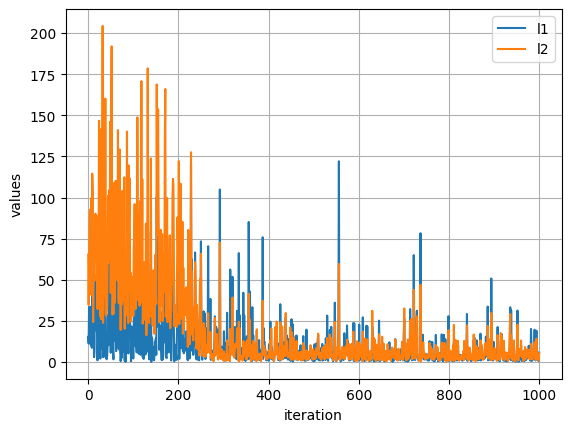

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
loss_dir = os.path.expanduser("~/Downloads")
loss_df = pd.read_csv(loss_dir + "/loss_latest.csv", index_col=0)
print("loss_df: ", loss_df)
for col in loss_df.columns:
    # if col == "l1" or col == "l2" or col == "l5":
    plt.plot(loss_df[col], label=col)
plt.xlabel("iteration")
plt.ylabel("values")
plt.legend()
plt.grid(True)
plt.show()